<a href="https://colab.research.google.com/github/azrankalo123/Quant_corner/blob/main/Mean_Variance_Criteria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="6">Portfolio Optimization under Mean Variance Criteria
</font>


By Asst.Prof.Dr. Udomsak Rakwongwan and Mr.Krittipat Krittakom.\
The content is allowed to be freely distributed for educational purposes with credit to the authurs.

# STEP 1: Install necessary packages

In [ ]:
#package for retriving data from Yahoo Finance
#package for optimization
#package for ploting graphs

In [ ]:
!pip install yfinance

In [ ]:
!pip install cvxpy

In [ ]:
!pip install plotly

# STEP 2: Import packages

In [ ]:
#package to handle dataframes (tables)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yahooFinance
import datetime
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
%config InlineBackend.figure_format='retina'

# STEP 3: Import data from Yahoo Finance

In [ ]:
#define the list of tickers you want to import the data for
name_of_asset_list = ['AAPL','MSFT','GOOG','AMZN','TSLA']

In [ ]:
#specify the start and the end dates for the historical data
startDate = datetime.datetime(2018, 1 ,1)
endDate = datetime.datetime(2021, 12, 31)
for asset in name_of_asset_list:
    #create a Yahoo Finance handle to perform
    import_data = yahooFinance.Ticker(asset)
    #import the data for each ticker in the list for the specified period
    data_pandas = import_data.history(start = startDate, end = endDate)
    #write the data to csv file
    data_pandas.to_csv('%s.csv'%asset)

In [ ]:
#example of AAPL data
pd.read_csv('AAPL.csv', index_col = 0)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-01-02 00:00:00-05:00,40.226428,40.732332,40.013663,40.722874,102223600,0.0,0.0
2018-01-03 00:00:00-05:00,40.786708,41.264244,40.651960,40.715786,118071600,0.0,0.0
2018-01-04 00:00:00-05:00,40.789068,41.008925,40.680325,40.904907,89738400,0.0,0.0
2018-01-05 00:00:00-05:00,41.001820,41.458077,40.909623,41.370609,94640000,0.0,0.0
2018-01-08 00:00:00-05:00,41.216957,41.514824,41.117664,41.216957,82271200,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-23 00:00:00-05:00,173.863500,174.852203,173.290050,174.288635,68356600,0.0,0.0
2021-12-27 00:00:00-05:00,175.089473,178.381857,175.069710,178.292877,74919600,0.0,0.0
2021-12-28 00:00:00-05:00,178.124800,179.281581,176.513209,177.264618,79144300,0.0,0.0


# STEP 4: Estimate the modeling parameters for the optimization

In this example, we assume that the investing horizon $T$ is 30 days and the log return of each asset is normally distributed.\
In other words, the log return $\hat{R_T}=[R^1_T R^2_T ... R^n_T]$ of the $n$ assets is normally distributed with mean $\mu_T$ and covariance $\Sigma_T$.

However, as we have daily data for each asset, we can calculate $\mu_{d}$ and $\Sigma_{d}$ for the daily data and then scale them to 30 days by setting

$$\mu_T=\mu_{d}\times 30 \quad \text{and}\quad \Sigma_T=\Sigma_d\times 30.$$

Let $\hat{S_t}=[S^1_t S^2_t ... S^n_t]$ denotes the vector of the daily prices of the $n$ assets at time t.

1. Find the vector of the log returns $\hat{R_t}=[R^1_t R^2_t ... R^n_t]$, where
$$R^i_t=\ln(\frac{S^i_{t+1}}{S^i_t}).$$

2. Find $\mu_{d}$ and $\Sigma_{d}$ by calculating the mean and the covariance of $\hat{R_t}$.

3. Calculate $\mu_T=\mu_{d}\times 30$ and $\Sigma_T=\Sigma_{d}\times 30$.



In [ ]:
#define a function to extract close prices from the file
def Get_Close_Price(csv_file, name_of_asset):
    raw_data = pd.read_csv('%s.csv'%csv_file, index_col = 0)
    Close = raw_data[['Close']]
    Close.rename(columns = {'Close':'%s'%name_of_asset}, inplace = True)
    return Close

In [ ]:
#get close prices for each asset
AAPL = Get_Close_Price('AAPL', 'AAPL')
MSFT = Get_Close_Price('MSFT', 'MSFT')
GOOG = Get_Close_Price('GOOG', 'GOOG')
AMZN = Get_Close_Price('AMZN', 'AMZN')
TSLA = Get_Close_Price('TSLA', 'TSLA')
#remove data where the prices do not exist
Closed_Prices = pd.concat([AAPL,MSFT,GOOG,AMZN,TSLA], axis = 1).dropna()

<ipython-input-11-80b5665f9860>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Close.rename(columns = {'Close':'%s'%name_of_asset}, inplace = True)
<ipython-input-11-80b5665f9860>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Close.rename(columns = {'Close':'%s'%name_of_asset}, inplace = True)
<ipython-input-11-80b5665f9860>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Close.rename(columns = {'Close':'%s'%name_of_asset}, inpla

In [ ]:
#example of close price of APPL
AAPL

,AAPL
Date,
2018-01-02 00:00:00-05:00,40.722878
2018-01-03 00:00:00-05:00,40.715778
2018-01-04 00:00:00-05:00,40.904907
2018-01-05 00:00:00-05:00,41.370621
2018-01-08 00:00:00-05:00,41.216957
...,...
2021-12-23 00:00:00-05:00,174.288620
2021-12-27 00:00:00-05:00,178.292877
2021-12-28 00:00:00-05:00,177.264603


In [ ]:
#concatenate the closing prices of all tickers in one dataframe
close_Prices = pd.concat([AAPL,MSFT,GOOG,AMZN,TSLA], axis = 1)

In [ ]:
#display the closing prices
close_Prices

,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2018-01-02 00:00:00-05:00,40.722878,80.228996,53.250000,59.450500,21.368668
2018-01-03 00:00:00-05:00,40.715778,80.602379,54.124001,60.209999,21.150000
2018-01-04 00:00:00-05:00,40.904907,81.311790,54.320000,60.479500,20.974667
2018-01-05 00:00:00-05:00,41.370621,82.319923,55.111500,61.457001,21.105333
2018-01-08 00:00:00-05:00,41.216957,82.403900,55.347000,62.343498,22.427334
...,...,...,...,...,...
2021-12-23 00:00:00-05:00,174.288620,328.668732,147.142502,171.068497,355.666656
2021-12-27 00:00:00-05:00,178.292877,336.289124,148.063995,169.669495,364.646667
2021-12-28 00:00:00-05:00,177.264603,335.110687,146.447998,170.660995,362.823334


Calculate $\hat{R_t}=[R^1_t R^2_t ... R^n_t]$, where
$$R^i_t=\ln(\frac{S^i_{t+1}}{S^i_t}).$$

In [ ]:
#remove the first row of the dataframe
S_t_plus_1 =close_Prices.drop(close_Prices.index[0])
S_t_plus_1

,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2018-01-03 00:00:00-05:00,40.715778,80.602379,54.124001,60.209999,21.150000
2018-01-04 00:00:00-05:00,40.904907,81.311790,54.320000,60.479500,20.974667
2018-01-05 00:00:00-05:00,41.370621,82.319923,55.111500,61.457001,21.105333
2018-01-08 00:00:00-05:00,41.216957,82.403900,55.347000,62.343498,22.427334
2018-01-09 00:00:00-05:00,41.212223,82.347916,55.313000,62.634998,22.246000
...,...,...,...,...,...
2021-12-23 00:00:00-05:00,174.288620,328.668732,147.142502,171.068497,355.666656
2021-12-27 00:00:00-05:00,178.292877,336.289124,148.063995,169.669495,364.646667
2021-12-28 00:00:00-05:00,177.264603,335.110687,146.447998,170.660995,362.823334


In [ ]:
#remove the last row of the dataframe
S_t = close_Prices.drop(close_Prices.index[-1])
S_t

,AAPL,MSFT,GOOG,AMZN,TSLA
Date,,,,,
2018-01-02 00:00:00-05:00,40.722878,80.228996,53.250000,59.450500,21.368668
2018-01-03 00:00:00-05:00,40.715778,80.602379,54.124001,60.209999,21.150000
2018-01-04 00:00:00-05:00,40.904907,81.311790,54.320000,60.479500,20.974667
2018-01-05 00:00:00-05:00,41.370621,82.319923,55.111500,61.457001,21.105333
2018-01-08 00:00:00-05:00,41.216957,82.403900,55.347000,62.343498,22.427334
...,...,...,...,...,...
2021-12-22 00:00:00-05:00,173.655853,327.205536,146.949005,171.037003,336.290009
2021-12-23 00:00:00-05:00,174.288620,328.668732,147.142502,171.068497,355.666656
2021-12-27 00:00:00-05:00,178.292877,336.289124,148.063995,169.669495,364.646667


In [ ]:
#calculate the log return as defined
R_t = pd.DataFrame(np.log(S_t_plus_1.values/S_t.values), columns = close_Prices.columns.tolist(), index = close_Prices.index.tolist()[1:])

In [ ]:
#display the log return
R_t

,AAPL,MSFT,GOOG,AMZN,TSLA
2018-01-03 00:00:00-05:00,-0.000174,0.004643,0.016280,0.012694,-0.010286
2018-01-04 00:00:00-05:00,0.004634,0.008763,0.003615,0.004466,-0.008325
2018-01-05 00:00:00-05:00,0.011321,0.012322,0.014466,0.016033,0.006210
2018-01-08 00:00:00-05:00,-0.003721,0.001020,0.004264,0.014322,0.060755
2018-01-09 00:00:00-05:00,-0.000115,-0.000680,-0.000615,0.004665,-0.008118
...,...,...,...,...,...
2021-12-23 00:00:00-05:00,0.003637,0.004462,0.001316,0.000184,0.056020
2021-12-27 00:00:00-05:00,0.022715,0.022921,0.006243,-0.008212,0.024935
2021-12-28 00:00:00-05:00,-0.005784,-0.003510,-0.010974,0.005827,-0.005013
2021-12-29 00:00:00-05:00,0.000502,0.002049,0.000386,-0.008592,-0.002097


Compute $\mathbf{\mu_d}$ and $\Sigma_d$

In [ ]:
mu_d = np.asarray(np.mean(R_t.values.T, axis = 1)) # daily
Sigma_d = np.asmatrix(np.cov(R_t.values.T)) # daily

In [ ]:
#scale daily mu and Sigma to 30 days
mu = mu_d*30 # 30 days
Sigma = Sigma_d*30 # 30 days

In [ ]:
#display mu
mu

array([0.04368058, 0.04246235, 0.03007831, 0.03109291, 0.0839521 ])

In [ ]:
#display Sigma
Sigma

matrix([[0.01291143, 0.0088976 , 0.00773216, 0.00791859, 0.01084779],
        [0.0088976 , 0.01062076, 0.0082187 , 0.00791485, 0.01025052],
        [0.00773216, 0.0082187 , 0.01015064, 0.00727969, 0.0084304 ],
        [0.00791859, 0.00791485, 0.00727969, 0.01157778, 0.00928317],
        [0.01084779, 0.01025052, 0.0084304 , 0.00928317, 0.0501536 ]])

# STEP 5: Find the optimal portfolio

The optimal portfolio $x$ is a vector of weights which yields the minimum portfolio return variance subject to required return constraint and the cost constraint. Mathematically, the problem is the find the solution of

$$\begin{aligned}
	        \min_X \quad         & X^\top\Sigma X,\\
	        \textrm{subject to} \quad   & X^\top\boldsymbol{\mu}\geq r,\\
	        \textrm{and} \quad          & X^\top1=1.
	\end{aligned}$$

In [ ]:
#create the decision variable x with lenth equals the length of mu
X = cp.Variable(len(mu))
#define the required return (3 percent per month in this example)
r = 0.03

#define the objective function
Portfolio_Risk = cp.quad_form(X,Sigma)
Objective = cp.Minimize(Portfolio_Risk)

#define constraints
Portfolio_Return = X.T*mu
Constraints = [Portfolio_Return >= r,sum(X)==1]

#solve the optimization problem
cp.Problem(Objective, Constraints).solve()

#extract the optimal portfolio
optimal_Portfolio = X.value

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


In [ ]:
#display the optimal portfolio
optimal_Portfolio

array([ 0.13562324,  0.19690368,  0.40331687,  0.28072365, -0.01656744])

In [ ]:
#plot the optimal portfolio
fig = px.bar(x = name_of_asset_list, y = optimal_Portfolio, text_auto = '.4')
fig.update_layout(xaxis_title = 'Asset', yaxis_title = 'Proportion', title = 'Portfolio Proportion')
fig.show()

In [ ]:
#display portfolio return and risk
Portfolio_Risk_Base = Portfolio_Risk.value
print(Portfolio_Return.value)
print(Portfolio_Risk.value)

0.03375382805859637
0.008664789694186239


# STEP 6: Simulation of the future returns of the assets and the portfolio

Please note that we assume that the vector of the log returns of the assets is normally distributed with mean $\mu$ and covariance $\Sigma$. Calculating the future return of the optimal portfolio can be done by

1. Simulate $m$ scenarios of the vector of the log returns from the normal distribution with mean $\mu$ and covariance $\Sigma$.
2. Calculate the portfolio return of the optimal portfolio by multiplying the simulated vector of the log return to the vector of the optimal weights.

In [ ]:
def Multivariate_simulation(scenario, Mean, Cov):
    """Simulate the expected return of each asset.

    Args:
        scenario (int): Number of scenarios to simulate.
        Mean (1-D array): Mean list.
        Cov (n-D array): Covariance matrix.

    Returns:
        n-D array: Matrix of scenarios of the expected return of each asset.
    """
    number_of_assets = len(Mean)

    # Generate random samples from a multivariate normal distribution
    mean_simulation = np.random.multivariate_normal(np.zeros(number_of_assets), Cov, size=scenario)

    # Shift the simulated values by the mean to obtain scenarios of expected returns
    return mean_simulation + Mean

#simulate 100,000 scenarios of the vector of the log returns of the assets.
Simulated_Return = Multivariate_simulation(scenario = 100000, Mean = mu, Cov = Sigma)
#calculate the portfolio return based on the simulated returns.
Simulated_Portfolio_Return = [np.dot(optimal_Portfolio,Simulated_Return[i]) for i in range(len(Simulated_Return))]

([<matplotlib.axis.XTick at 0x78db36c01300>,
 [Text(-0.4662461719414036, 0, '−0.466'),
  Text(-0.36624617194140363, 0, '−0.366'),
  Text(-0.26624617194140365, 0, '−0.266'),
  Text(-0.16624617194140365, 0, '−0.166'),
  Text(-0.06624617194140364, 0, '−0.066'),
  Text(0.03375382805859637, 0, '0.034'),
  Text(0.13375382805859637, 0, '0.134'),
  Text(0.23375382805859637, 0, '0.234'),
  Text(0.33375382805859644, 0, '0.334'),
  Text(0.4337538280585964, 0, '0.434'),
  Text(0.5337538280585964, 0, '0.534')])

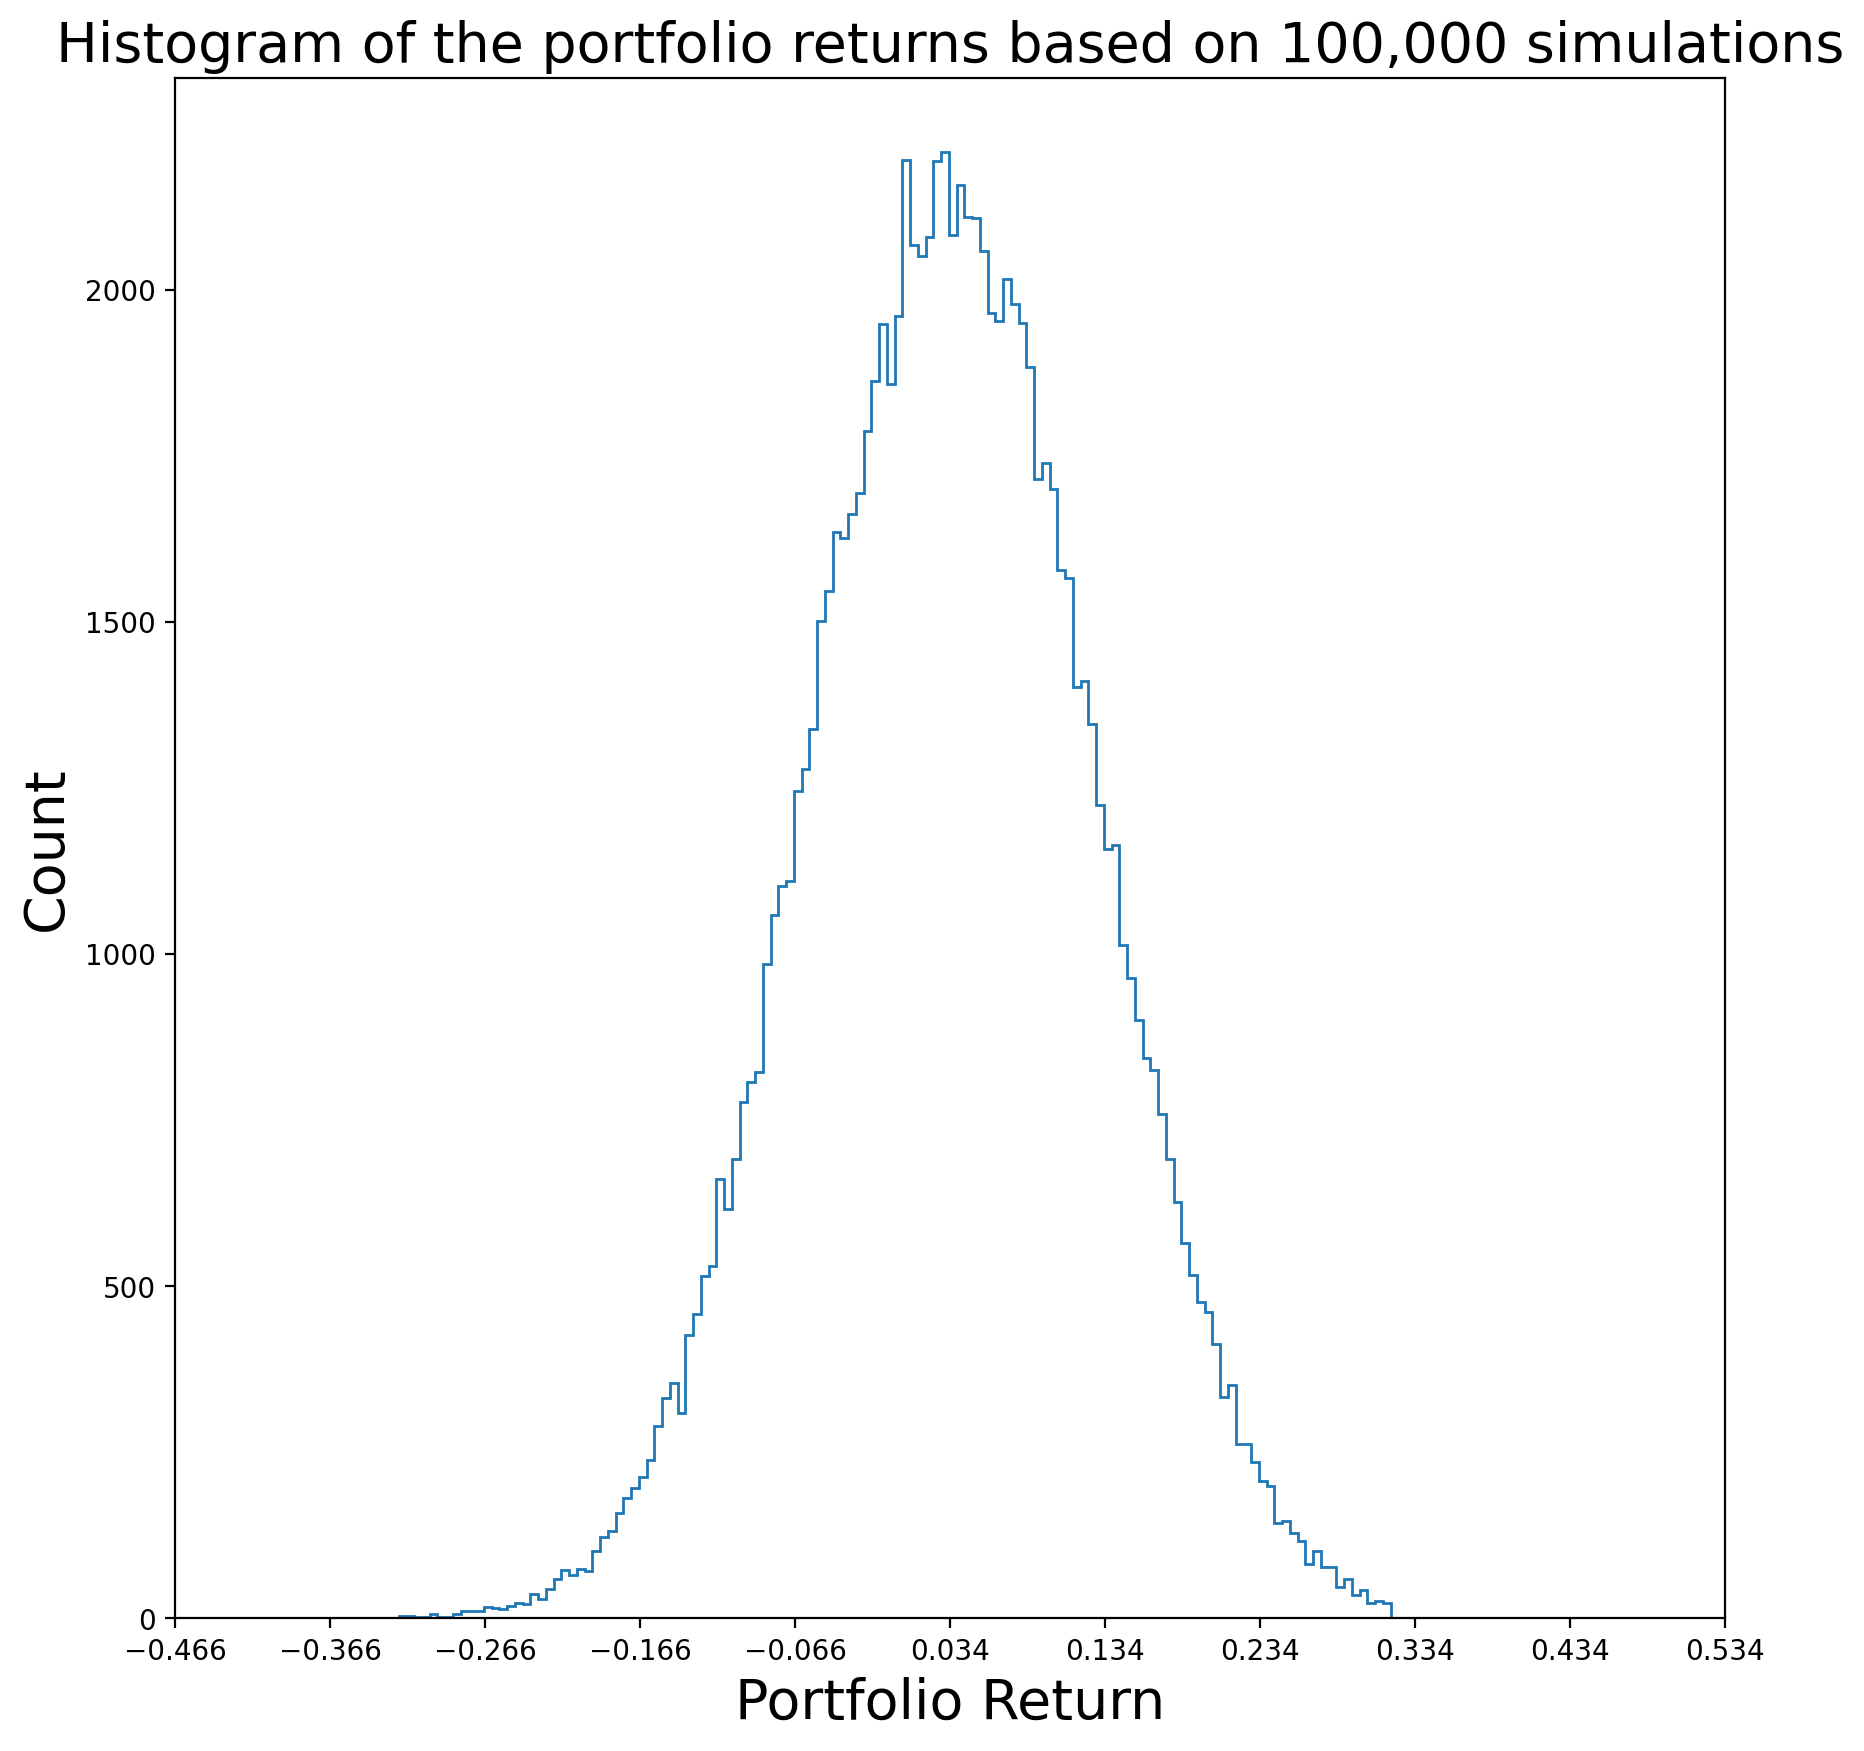

In [ ]:
#plot the histogram of the portfolio returns.
fig, ax =plt.subplots(figsize = (10, 10))
step = int(abs(min(Simulated_Portfolio_Return))*2/0.005+1)
bins = [min(Simulated_Portfolio_Return)+0.005*i for i in range(step)]
ax.hist(Simulated_Portfolio_Return, bins, histtype = 'step')
#ax.hist(Simulated_Payoff*2, bins, histtype = 'step')
ax.set_title('Histogram of the portfolio returns based on 100,000 simulations', fontsize = 20)
ax.set_xlabel('Portfolio Return', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
plt.xticks([Portfolio_Return.value+0.1*i for i in range(-5,6)])

# STEP 7: Comparison of the portfolios  obtained with two different required returns

In [ ]:
#change the return from 0.03 to 0.08
Y = cp.Variable(len(mu))
r2 = 0.08

#define the objective function
Portfolio_Risk2 = cp.quad_form(Y,Sigma)
Objective2 = cp.Minimize(Portfolio_Risk2)

#define constraints
Portfolio_Return2 = Y.T*mu
Constraints2 = [Portfolio_Return2 >= r2,sum(Y)==1]

#solve the optimization problem
cp.Problem(Objective2, Constraints2).solve()

#extract the optimal portfolio
optimal_Portfolio2 = Y.value

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning:


This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.




In [ ]:
#plot the optimal portfolio
fig = px.bar(x = name_of_asset_list, y = optimal_Portfolio2, text_auto = '.4')
fig.update_layout(xaxis_title = 'Asset', yaxis_title = 'Proportion', title = 'Portfolio Proportion')
fig.show()

([<matplotlib.axis.XTick at 0x78db36970820>,
 [Text(-0.42, 0, '−0.42'),
  Text(-0.32, 0, '−0.32'),
  Text(-0.22000000000000003, 0, '−0.22'),
  Text(-0.12, 0, '−0.12'),
  Text(-0.01999999999999999, 0, '−0.02'),
  Text(0.08000000000000002, 0, '0.08'),
  Text(0.18000000000000002, 0, '0.18'),
  Text(0.28, 0, '0.28'),
  Text(0.38000000000000006, 0, '0.38'),
  Text(0.48000000000000004, 0, '0.48'),
  Text(0.5800000000000001, 0, '0.58')])

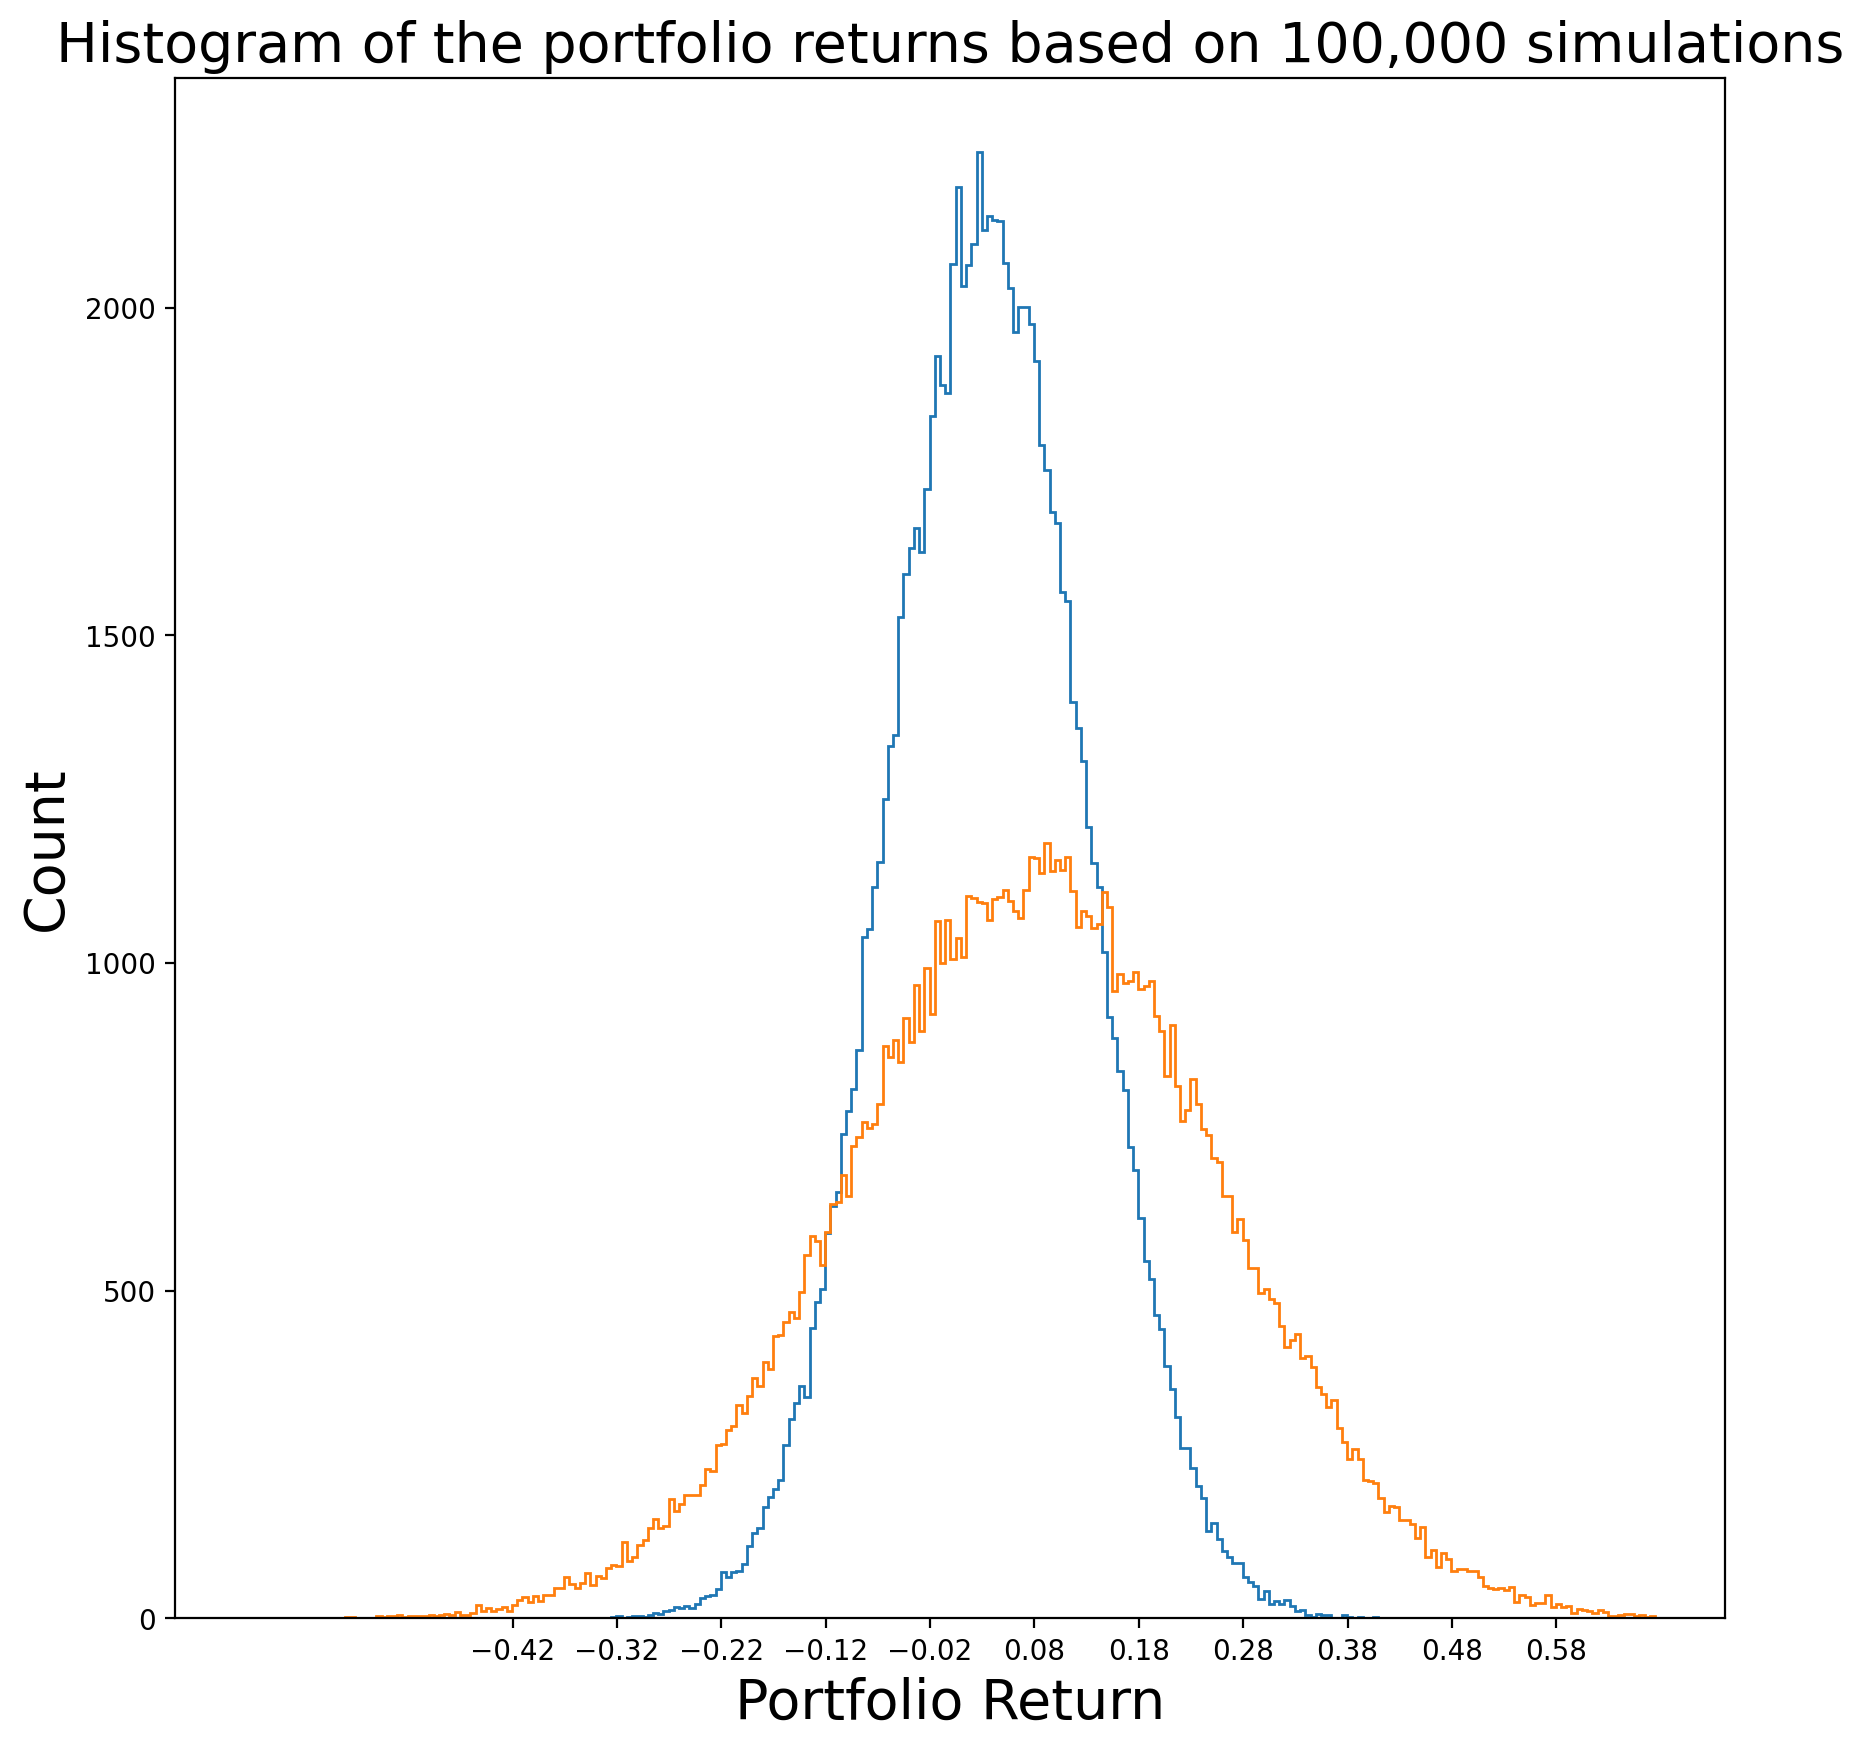

In [ ]:
#simulate and plot the portfolio return for r=0.08
#simulate 100,000 scenarios of the vector of the log returns of the assets.
Simulated_Return2 = np.random.multivariate_normal(mu, Sigma, 100000)
#calculate the portfolio return based on the simulated returns.
Simulated_Portfolio_Return2 = [np.dot(optimal_Portfolio2,Simulated_Return2[i]) for i in range(len(Simulated_Return2))]
#plot the histogram of the portfolio returns.
fig, ax =plt.subplots(figsize = (10, 10))
step = int(abs(min(Simulated_Portfolio_Return2))*2/0.005+1)
bins = [min(Simulated_Portfolio_Return2)+0.005*i for i in range(step)]
ax.hist(Simulated_Portfolio_Return, bins, histtype = 'step')
ax.hist(Simulated_Portfolio_Return2, bins, histtype = 'step')
ax.set_title('Histogram of the portfolio returns based on 100,000 simulations', fontsize = 20)
ax.set_xlabel('Portfolio Return', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
plt.xticks([Portfolio_Return2.value+0.1*i for i in range(-5,6)])

# STEP 8: Efficient frontier

The efficient frontier is a plot between the required returns and the minimum SDs obtained with optimal portfolio. The compuatation steps are

1. Determine the range of required returns you want to plot the efficient frontier for.
2. For each required return, perform the optimization to find the optimal portfolio.
3. Find the minimum SD coresponding with the optimal portfolio.
4. Plot between the minimum SDs and the required returns.

In [ ]:
X = cp.Variable(len(mu))
#define the list of required return from 0.03 to 0.08
R_list = np.arange(0.03,0.08+0.001,0.001)
Portfolio_Risk = cp.quad_form(X,Sigma)
Portfolio_Return = X.T@mu
Objective = cp.Minimize(Portfolio_Risk)
SD_Short = []
for R in R_list:
    Constraints = [Portfolio_Return >= R, sum(X)==1]
    cp.Problem(Objective, Constraints).solve()
    SD_Short.append(cp.sqrt(Portfolio_Risk).value.tolist())

In [ ]:
#put the required returns and the minimum SDs obtained with optimal portfolios in a table
Efficient_Frontier_Table = pd.DataFrame({'Required Return':R_list, 'Minimum SD':np.array(SD_Short)})

In [ ]:
#display the table
Efficient_Frontier_Table

,Required Return,Minimum SD
0,0.030,0.093085
1,0.031,0.093085
2,0.032,0.093085
3,0.033,0.093085
4,0.034,0.093088
5,0.035,0.093171
6,0.036,0.093366
7,0.037,0.093671
8,0.038,0.094086
9,0.039,0.094609


In [ ]:
#plot the efficient frontier
fig = px.line(Efficient_Frontier_Table, x = 'Minimum SD', y = 'Required Return')
fig.update_layout(title = 'The efficient frontier')
fig.show()

# STEP 9: Optimal portfolio with and without no-short constraint

Now, we considering the optimal portfolio when short selling is not allowed. In other words, an agent is not allowed to take negative positions in any assets. Mathematically, we have that $x_i\geq 0$ for all $i$.

Our optimization model then becomes

$$\begin{aligned}
	        \min_X \quad         & X^\top\Sigma X,\\
	        \textrm{subject to} \quad   & X^\top\boldsymbol{\mu}\geq r,\\
	        \textrm{and} \quad          & X^\top1=1,\\
            \textrm{and} \quad			& X_i \geq 0\quad \text{for all} \ i.
\end{aligned}$$

In [ ]:
X_Noshort = cp.Variable(len(mu))
R = 0.03
Portfolio_Risk_Noshort = cp.quad_form(X_Noshort,Sigma)
Portfolio_Return_Noshort = X_Noshort.T@mu
Objective_Noshort = cp.Minimize(Portfolio_Risk_Noshort)
#no short selling constraint
Constraints_Noshort = [Portfolio_Return_Noshort >= R, sum(X_Noshort)==1, X_Noshort>=0]
cp.Problem(Objective_Noshort, Constraints_Noshort).solve()
optimal_Portfolio_No_Short = X_Noshort.value
No_short_Return = Portfolio_Return_Noshort.value
No_short_Risk = Portfolio_Risk_Noshort.value
fig = px.bar(x = name_of_asset_list, y = optimal_Portfolio_No_Short, text_auto = '.4')
fig.update_layout(xaxis_title = 'Asset', yaxis_title = 'Proportion', title = 'Portfolio Proportion')
fig.show()

In [ ]:
Simulated_Return_Noshort = np.random.multivariate_normal(mu, Sigma, 100000)
Simulated_Portfolio_Return = [np.dot(optimal_Portfolio,Simulated_Return[i]) for i in range(len(Simulated_Return))]
Simulated_Portfolio_Return_No_Short = [np.dot(optimal_Portfolio_No_Short,Simulated_Return[i]) for i in range(len(Simulated_Return))]

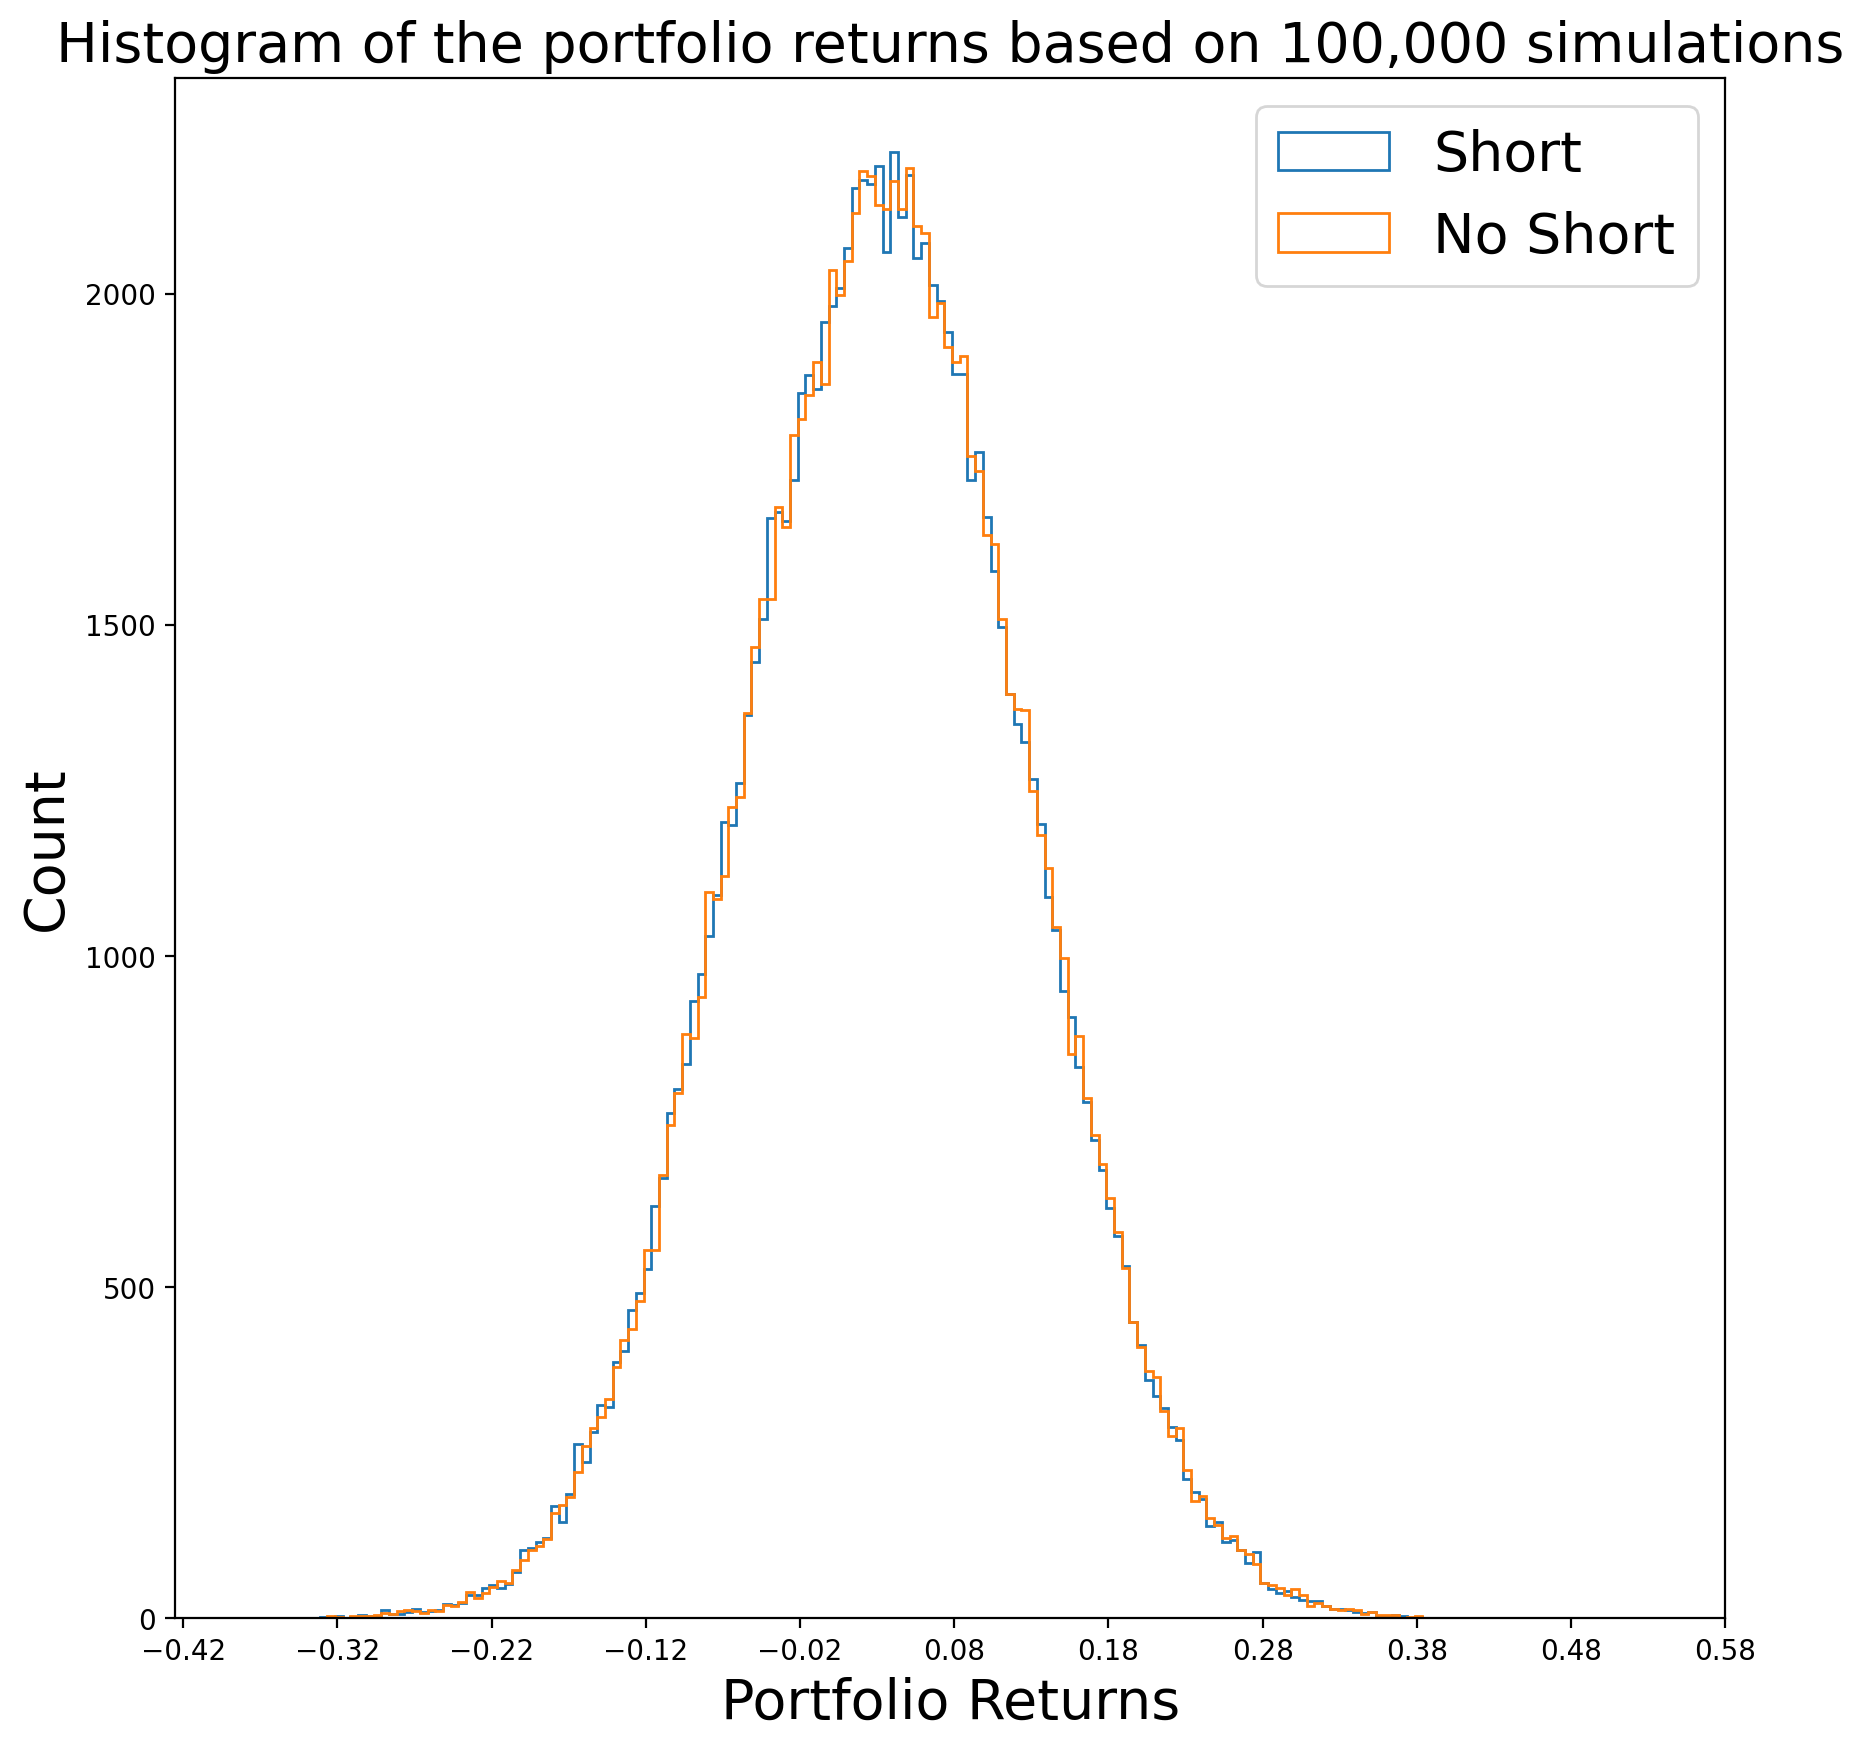

In [ ]:
fig, ax =plt.subplots(figsize = (10, 10))
step = int(abs(min(Simulated_Portfolio_Return))*2/0.005+1)
bins = [min(Simulated_Portfolio_Return)+0.005*i for i in range(step)]
ax.hist(Simulated_Portfolio_Return, bins, histtype = 'step', label = 'Short')
ax.hist(Simulated_Portfolio_Return_No_Short, bins, histtype = 'step', label = 'No Short')
ax.set_title('Histogram of the portfolio returns based on 100,000 simulations', fontsize = 20)
ax.set_xlabel('Portfolio Returns', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
plt.xticks([Portfolio_Return.value+0.1*i for i in range(-5,6)])
plt.legend(fontsize = 20)

In [ ]:
Portfolio_Risk_Base

0.008664792372721766

In [ ]:
No_short_Risk

0.008675536121908507

Plot the efficient frontiers with and without no-short selling constraint.

In [ ]:
X = cp.Variable(len(mu))
R_list = np.arange(0.03,0.08+0.001,0.001)
Portfolio_Risk = cp.quad_form(X,Sigma)
Portfolio_Return = mu.T@X
Objective = cp.Minimize(Portfolio_Risk)
Return_Short = []
SD_Short = []
Return_No_Short = []
SD_No_Short = []
for R in R_list:
    Constraints = [Portfolio_Return >= R, sum(X)==1]
    cp.Problem(Objective, Constraints).solve()
    Return_Short.append(Portfolio_Return.value.tolist())
    SD_Short.append(cp.sqrt(Portfolio_Risk).value.tolist())
    Constraints = [Portfolio_Return >= R, sum(X)==1, X>=0]
    cp.Problem(Objective, Constraints).solve()
    Return_No_Short.append(Portfolio_Return.value.tolist())
    SD_No_Short.append(cp.sqrt(Portfolio_Risk).value.tolist())

In [ ]:
Efficient_Frontier_Table = pd.DataFrame({'Return':np.concatenate((R_list,R_list)), 'SD':np.array(SD_Short+SD_No_Short), 'Constraints':['Short' for i in range(len(Return_Short))]+['No Short' for i in range(len(Return_No_Short))]})

In [ ]:
Efficient_Frontier_Table

,Return,SD,Constraints
0,0.030,0.093085,Short
1,0.031,0.093085,Short
2,0.032,0.093085,Short
3,0.033,0.093085,Short
4,0.034,0.093088,Short
...,...,...,...
97,0.076,0.190330,No Short
98,0.077,0.194443,No Short
99,0.078,0.198587,No Short
100,0.079,0.202762,No Short


In [ ]:
fig = px.line(Efficient_Frontier_Table, x = 'SD', y = 'Return', color = 'Constraints')
fig.update_layout(title = 'The efficient frontier')
fig.show()